Title: "Stock Correlation Analysis"<br>
Author: "Nagarjunan Saravanan"<br>
Date: "2024-12-20"<br>
Output: Data_Visualization for the Correlation using Heatmap, Network graph, PCA Variance, PCA Scatter plot and Streamlit Dashboard.

# Stock Correlation Analysis
This project aims to analyze the correlation between stock prices, reduce dimensionality using Principal Component Analysis (PCA), and cluster stocks into groups based on their similarities. It provides visualizations and insights to simplify stock market analysis.

## Objective<br>
The goal of this project is to:

- Fetch stock data for selected companies.
- Analyze correlations between stock price movements.
- Apply dimensionality reduction using PCA to uncover latent patterns.
- Cluster stocks based on their behavior.
- Provide a user-friendly interface for uploading custom stock data.

#### Key Steps
1. Data Fetching

In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans

In [2]:
# fetching the Historical Data
def fetch_stock_data(tickers, start_date, end_date, interval='1d'):
    data = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_date, end=end_date, interval=interval)
        data[ticker] = hist['Close']
    return pd.DataFrame(data)

tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
stock_data = fetch_stock_data(tickers, "2020-01-01", "2023-01-01")

  <b>Explanation:</b><br>
  - The yfinance library is used to fetch historical stock data.
  - Input: A list of stock tickers, date range, and interval.
  - Output: A DataFrame containing the stock prices.

2. Correlation Analysis<br>
<b>Steps:</b>
    - Calculate the correlation matrix for stock prices.
    - Identify strong and weak correlations:
    - Strong correlations: Values > 0.8 (but not 1).
    - Weak correlations: Values < -0.8.
    - Visualize the correlation matrix using a heatmap.

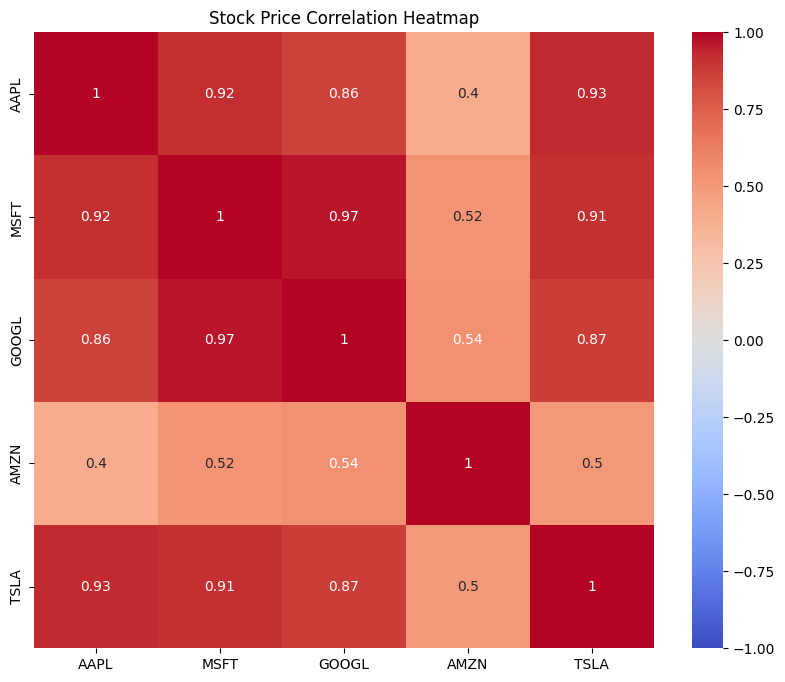

In [3]:
# constructing correlation matrix
correlation_matrix = stock_data.corr()

# Visualize heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Stock Price Correlation Heatmap")
plt.show()


<b>Purpose:</b><br>
- The heatmap reveals relationships between stock price movements. Highly correlated stocks often belong to the same sector or respond similarly to market events.

3. Network Visualization<br>
<b>Steps:</b><br>
    1. Create a graph using NetworkX where:
        - Nodes represent stocks.
        - Edges represent strong correlations (> 0.8).
    2. Visualize the network graph.

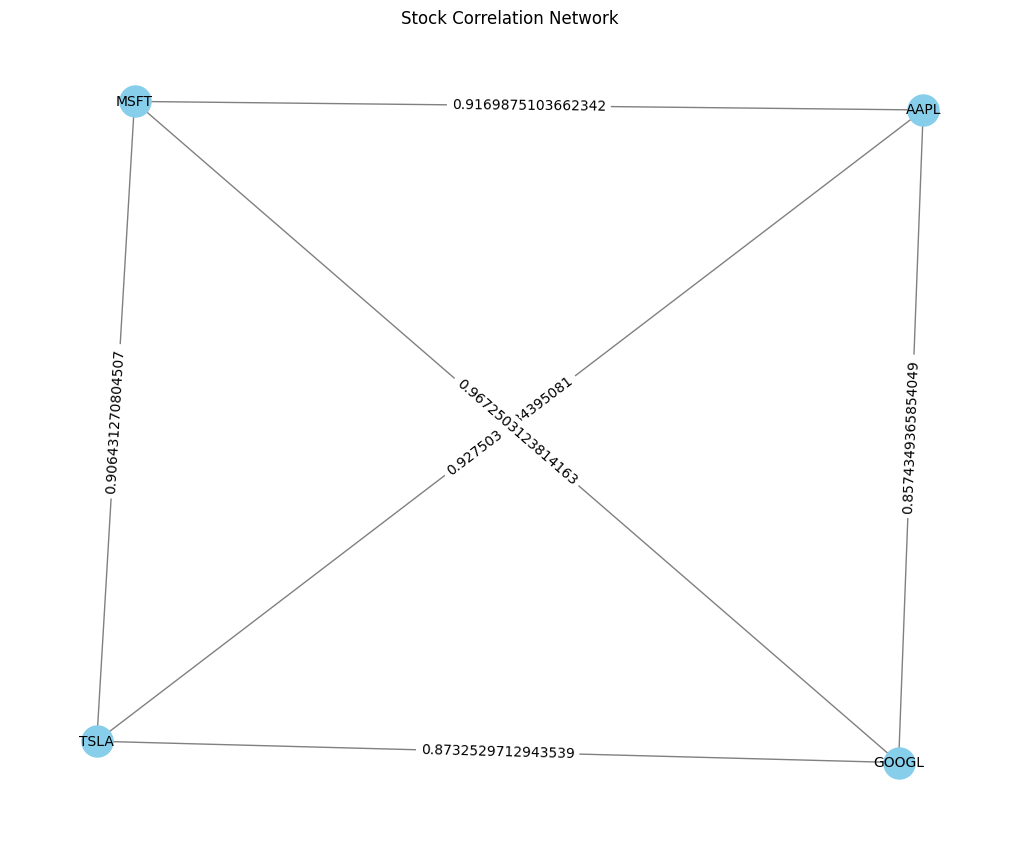

In [4]:
# Construct Network Graph
edges = [(i, j, {'weight': correlation_matrix.loc[i, j]})
         for i in correlation_matrix.index
         for j in correlation_matrix.columns
         if 0.8 < correlation_matrix.loc[i, j] < 1]

G = nx.Graph()
G.add_edges_from(edges)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, edge_color="gray")
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.title("Stock Correlation Network")
plt.show()


<b>Purpose:</b><br>
- Highlights clusters of stocks with similar behavior.
- Useful for portfolio diversification and risk management

4. Volatility Analysis<br>
<b>Steps:</b><br>
    - Calculate daily percentage changes in stock prices.
    - Compute the standard deviation (volatility) of percentage changes for each stock.

In [5]:
# compute volatility
volatility = stock_data.pct_change().std()
print(volatility)

AAPL     0.023266
MSFT     0.021895
GOOGL    0.021748
AMZN     0.024621
TSLA     0.045474
dtype: float64


<b>Purpose:</b><br>
- Identifies which stocks are more volatile, aiding in risk assessment.

5. Principal Component Analysis (PCA)<br>
<b>Steps:</b><br>
    1. Standardize Data:
        - Normalize percentage changes to have zero mean and unit variance.
    2. Apply PCA:
        - Reduce data to 2 components (Market Trend and Sector Trend).
    3. Visualize Explained Variance:
        - Bar chart showing variance explained by each principal component.
    4. Scatter Plot:
        - Stocks projected onto the 2D PCA space.

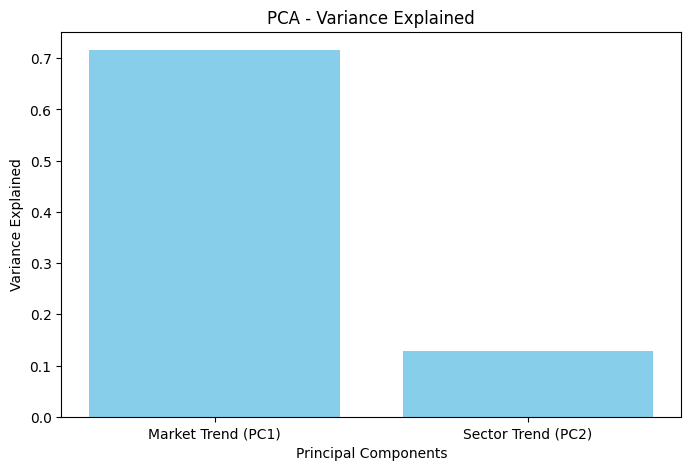

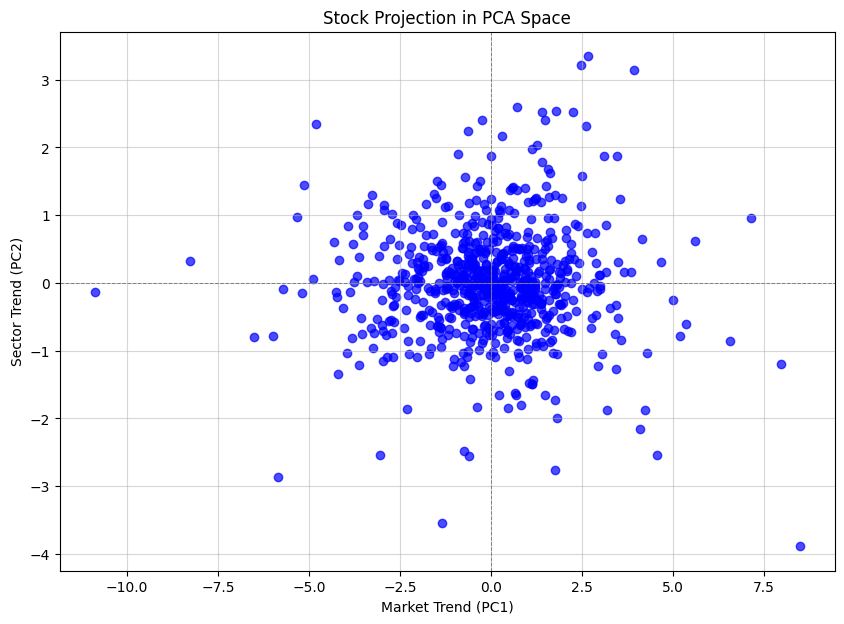

In [6]:
# Standardize data
returns = stock_data.pct_change().dropna()
standardized_data = (returns - returns.mean()) / returns.std()

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(standardized_data)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Visualization
plt.figure(figsize=(8, 5))
plt.bar(["Market Trend (PC1)", "Sector Trend (PC2)"], explained_variance, color="skyblue")
plt.xlabel("Principal Components")
plt.ylabel("Variance Explained")
plt.title("PCA - Variance Explained")
plt.show()

# Scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, color="blue")
plt.xlabel("Market Trend (PC1)")
plt.ylabel("Sector Trend (PC2)")
plt.title("Stock Projection in PCA Space")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)
plt.grid(alpha=0.5)
plt.show()


<b>Purpose:</b><br>
- Reduces the complexity of the data.
- PC1 (Market Trend): Represents overall market movement.
- PC2 (Sector Trend): Represents sector-specific variations.

7. Quality Measurement<br>
<b>Steps:</b><br>
    - Calculate R_Squared Value for the model to measure the quality of the Model.
    - Display the split up of the R_Squared Value for each PCA Component for detailed analysis.

In [7]:
# Calculate cumulative explained variance (R² value)
r_squared = np.sum(pca.explained_variance_ratio_)

# Print the R_Squared value
print(f"R_Squared Value (Variance Explained by PCA Model): {r_squared:.2f}")

# Optional: Display explained variance for each component
explained_variance_df = pd.DataFrame({
    "Principal Component": ["Market Trend (PC1)", "Sector Trend (PC2)"],
    "Variance Explained": pca.explained_variance_ratio_
})
print("\nExplained Variance by Component:")
print(explained_variance_df)

R_Squared Value (Variance Explained by PCA Model): 0.84

Explained Variance by Component:
  Principal Component  Variance Explained
0  Market Trend (PC1)            0.716061
1  Sector Trend (PC2)            0.127881


8. Clustering with K-Means<br>
<b>Steps:</b><br>
    - Use the correlation matrix as input for clustering.
    - Apply K-Means to group stocks into 3 clusters.
    - Assign cluster labels to stocks.

In [8]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(correlation_matrix)

# Add cluster labels
clustered_data = pd.DataFrame({"Stock": correlation_matrix.index, "Cluster": clusters})
print(clustered_data)


   Stock  Cluster
0   AAPL        2
1   MSFT        1
2  GOOGL        1
3   AMZN        0
4   TSLA        2


<b>Purpose:</b><br>
- Groups stocks based on their behavior.
- Useful for portfolio construction and identifying diversification opportunities.

8. Streamlit Integration<br>
<b>Steps:</b><br>
    - Create a user interface for uploading stock tickers as a CSV file.
    - Fetch stock data for the uploaded tickers.
    - Visualize correlation heatmap interactively.
    - This is done in a separate file 'stock_analysis.py'

In [10]:
stock_data.to_csv('stock_data.csv')

<b>Purpose:</b><br>
- Allows non-technical users to upload custom data and visualize insights.